# Using Transformer based Model — BERT
## Exploratory Data Analysis (EDA)
Load & Prepare the Data

In [ ]:
# Install & import necessary libraries
!pip install -q transformers
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight

from google.colab import drive
drive.mount('/content/drive')


<ipython-input-13-660c73f2ef0e>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


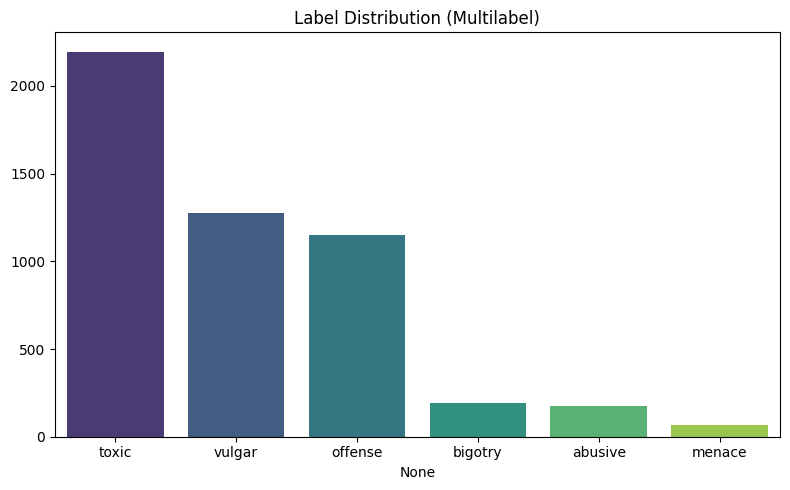

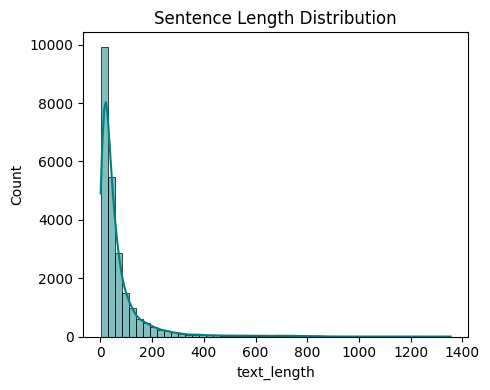

In [13]:
# Load dataset
train_df = pd.read_csv('/content/drive/MyDrive/ToxicityClassific dataset/train.csv')
val_df = pd.read_csv('/content/drive/MyDrive/ToxicityClassific dataset/validation.csv')

# Create binary offensive label in train
label_cols = ['toxic', 'abusive', 'vulgar', 'menace', 'offense', 'bigotry']
train_df['offensive'] = train_df[label_cols].max(axis=1)

# Label dist
plt.figure(figsize=(8, 5))
label_counts = train_df[label_cols].sum().sort_values(ascending=False)
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('Label Distribution (Multilabel)')
plt.tight_layout()
plt.show()

# Sentence length dist
train_df['text_length'] = train_df['feedback_text'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(5, 4))
sns.histplot(train_df['text_length'], bins=50, kde=True, color='teal')
plt.title('Sentence Length Distribution')
plt.tight_layout()
plt.show()



# Text Preprocessing

In [14]:
# my choosen model BERT generally handles raw text directly

# Initialize BERT tokenizer and model
MODEL_NAME = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = TFBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

# Generator-based TF dataset creation
def generate_tf_dataset(df, tokenizer, text_col, label_col=None, max_length=100, batch_size=16):
    def gen():
        for _, row in df.iterrows():
            encoded = tokenizer.encode_plus(
                row[text_col],
                add_special_tokens=True,
                max_length=max_length,
                padding='max_length',
                truncation=True,
                return_token_type_ids=False,
                return_attention_mask=True,
                return_tensors='tf',
            )
            x = {
                'input_ids': tf.squeeze(encoded['input_ids'], axis=0),
                'attention_mask': tf.squeeze(encoded['attention_mask'], axis=0)
            }
            if label_col is not None:
                y = tf.convert_to_tensor(row[label_col], dtype=tf.int64)
                yield x, y
            else:
                yield x

    output_signature = (
        {
            'input_ids': tf.TensorSpec(shape=(max_length,), dtype=tf.int32),
            'attention_mask': tf.TensorSpec(shape=(max_length,), dtype=tf.int32)
        },
        tf.TensorSpec(shape=(), dtype=tf.int64)
    ) if label_col else {
        'input_ids': tf.TensorSpec(shape=(max_length,), dtype=tf.int32),
        'attention_mask': tf.TensorSpec(shape=(max_length,), dtype=tf.int32)
    }

    return tf.data.Dataset.from_generator(gen, output_signature=output_signature).batch(batch_size)


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Model Creation,  Fine-tune BERT for Binary Classification

In [16]:
# Generate datasets
train_dataset = generate_tf_dataset(train_df, tokenizer, text_col='feedback_text', label_col='offensive')
val_dataset = generate_tf_dataset(val_df, tokenizer, text_col='feedback_text', label_col='toxic')

# Calculate class weights for imbalance
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['offensive']),
    y=train_df['offensive']
)



In [19]:
# Compile model
# model.compile(
#     optimizer='adam', # Changed from Adam(learning_rate=2e-5) to 'adam'
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     metrics=['accuracy']
# )

# Set learning rate after compilation if you need a specific value:
model.optimizer.lr.assign(2e-5)


# Train with class weights and multiple epochs
# model.fit(
#     train_dataset,
#     validation_data=val_dataset,
#     epochs=3,
#     class_weight=class_weights
# )

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=1.9999999494757503e-05>

# comment out the model running blocks as it is gonna saved

In [7]:
# Saving my Trained Model

# Save model and tokenizer to directory to run again in new env.
# model.save_pretrained('/content/bert_offensive__class_model')
# tokenizer.save_pretrained('/content/bert_offensive__class_model')

('/content/bert_offensive__class_model/tokenizer_config.json',
 '/content/bert_offensive__class_model/special_tokens_map.json',
 '/content/bert_offensive__class_model/vocab.txt',
 '/content/bert_offensive__class_model/added_tokens.json')

In [20]:
# Load my trained Model & Tokenizer from Saved Directory

from transformers import TFBertForSequenceClassification, BertTokenizer

model = TFBertForSequenceClassification.from_pretrained('/content/bert_offensive__class_model')
tokenizer = BertTokenizer.from_pretrained('/content/bert_offensive__class_model')

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


Some layers from the model checkpoint at /content/bert_offensive__class_model were not used when initializing TFBertForSequenceClassification: ['dropout_75']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/bert_offensive__class_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


# Model Evaluation

In [21]:

# Generate predictions
val_texts = val_df['feedback_text'].tolist()
val_labels = val_df['toxic'].tolist()

val_encodings = tokenizer(val_texts, truncation=True, padding=True, return_tensors='tf', max_length=100)
val_logits = model.predict(dict(val_encodings)).logits
val_probs = tf.nn.softmax(val_logits, axis=1).numpy()
val_preds = (val_probs[:, 1] >= 0.5).astype(int)

# Evaluation metrics
print("\nClassification Report – Validation Set:")
print(classification_report(val_labels, val_preds))

print(f"Accuracy: {accuracy_score(val_labels, val_preds):.3f}")
print(f"AUC-ROC Score: {roc_auc_score(val_labels, val_probs[:, 1]):.3f}")




27/27 [==============================] - 10s 207ms/step

Classification Report – Validation Set:
              precision    recall  f1-score   support

           0       0.86      0.98      0.92       706
           1       0.59      0.14      0.23       134

    accuracy                           0.85       840
   macro avg       0.73      0.56      0.57       840
weighted avg       0.82      0.85      0.81       840

Accuracy: 0.848
AUC-ROC Score: 0.598


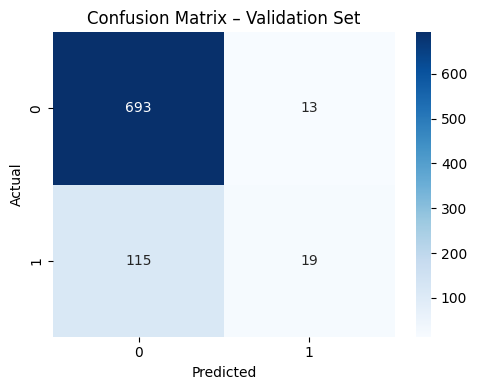

In [22]:
# Confusion Matrix
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix – Validation Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


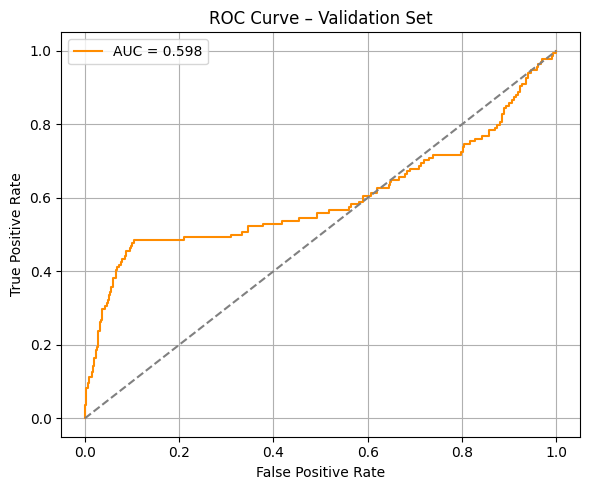

In [23]:
# ROC Curve
fpr, tpr, _ = roc_curve(val_labels, val_probs[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve – Validation Set')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Evaluation on test set

In [28]:
# Predict on test set
test_df = pd.read_csv('/content/drive/MyDrive/ToxicityClassific dataset/test.csv')
test_labels_df = pd.read_csv('/content/drive/MyDrive/ToxicityClassific dataset/test_labels.csv')

# Merge the 'offensive' labels from test_labels_df into test_df based on 'id'
test_df = test_df.merge(
    test_labels_df[['id', 'toxic']],
    on='id',
    how='left'
)

y_test= test_labels_df['toxic']

# test_pred = model.predict(X_test)
# test_prob = model.predict_proba(X_test)[:, 1]

In [32]:

# Generate predictions
val_texts = test_df['content'].tolist()
val_labels = test_df['toxic'].tolist()

val_encodings = tokenizer(val_texts, truncation=True, padding=True, return_tensors='tf', max_length=100)
val_logits = model.predict(dict(val_encodings)).logits
val_probs = tf.nn.softmax(val_logits, axis=1).numpy()
val_preds = (val_probs[:, 1] >= 0.5).astype(int)

# Evaluation metrics
print("\nClassification Report – Test Set:")
print(classification_report(val_labels, val_preds))

print(f"Accuracy: {accuracy_score(val_labels, val_preds):.3f}")
print(f"AUC-ROC Score: {roc_auc_score(val_labels, val_probs[:, 1]):.3f}")


188/188 [==============================] - 42s 223ms/step

Classification Report – Test Set:
              precision    recall  f1-score   support

           0       0.80      0.98      0.88      4637
           1       0.72      0.15      0.24      1363

    accuracy                           0.79      6000
   macro avg       0.76      0.56      0.56      6000
weighted avg       0.78      0.79      0.74      6000

Accuracy: 0.793
AUC-ROC Score: 0.610


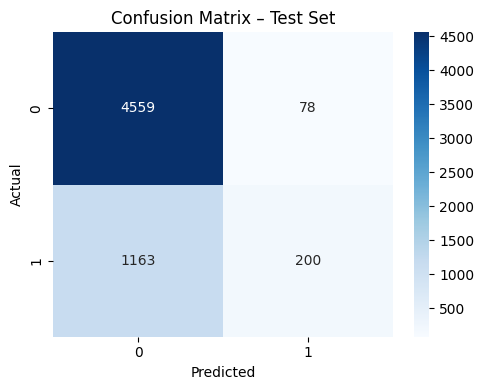

In [33]:
# Confusion Matrix
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix – Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


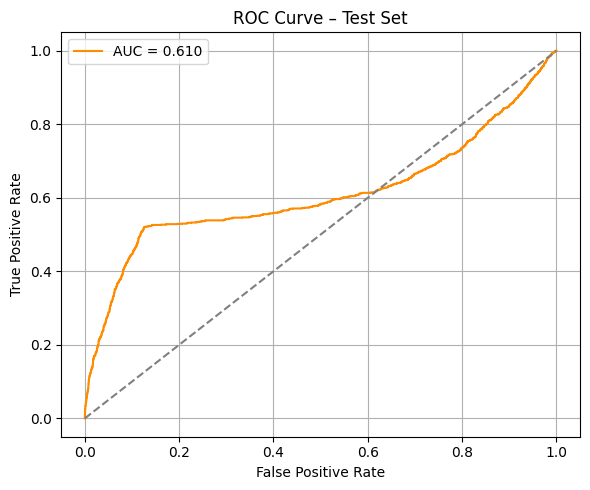

In [34]:
# ROC Curve
fpr, tpr, _ = roc_curve(val_labels, val_probs[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve – Test Set')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()